# Trabalho 1 - Inteligência Artificial

## 1. Instalar Dependências


In [ ]:
!pip install -q sentence-transformers scikit-learn pandas numpy matplotlib seaborn

## 2. Import de Bibliotecas


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuração para visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 3. Carregar os Dados


In [ ]:
# Upload do dataset
# OBSERVAÇÃO: Faça upload do arquivo dados_criticas.csv para o Colab
# Ou carregue de um link do Google Drive ou Hugging Face

# Opção 1: Upload manual (descomente se necessário)
# from google.colab import files
# uploaded = files.upload()

# Opção 2: Upload do Google Drive (descomente e ajuste o caminho)
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/MyDrive/Trabalho-IA-1/dados_criticas.csv')

# Opção 3: Carregar o arquivo local (se já estiver no ambiente)
df = pd.read_csv('dados_criticas.csv')

print(f"Total de amostras: {len(df)}")
print(f"\nDistribuição por classe:")
print(df['label'].value_counts())
print(f"\nPrimeiras linhas:")
df.head()


Total de amostras: 233

Distribuição por classe:
label
Positivo    199
Negativo     34
Name: count, dtype: int64

Primeiras linhas:


,texto,label,nota
0,MEU NOVO FILME TRUQUE DE MESTRE 3MEU nome ANDE...,Positivo,5.0
1,"Nada de novo, mas ainda consegue ser bom. É um...",Positivo,4.0
2,"Não tem como não dar certo, é puro entretenime...",Positivo,4.0
3,Um filme incrível! Eu não sou muito fã dessa j...,Positivo,4.5
4,Filme muito divertido até para os pais! Também...,Positivo,5.0


## 4. Pré-processamento dos Dados


In [ ]:
import re
import string

def preprocess_text(text):
    # Função para pré-processar os textos
    if pd.isna(text): return ""

    # Converter para string o texto
    text = str(text)

    # Remover as URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remover os caracteres especiais excessivos
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remover os espaços múltiplos
    text = re.sub(r'\s+', ' ', text)

    # Remover os espaços no início e fim
    text = text.strip()

    return text

# Aplicar pré-processamento
df['texto_processado'] = df['texto'].apply(preprocess_text)

# Remover os textos vazios após pré-processamento
df = df[df['texto_processado'].str.len() > 0]

# Verificar a distribuição após o pré-processamento
print(f"Total de amostras após pré-processamento: {len(df)}")
print(f"\nDistribuição por classe:")
print(df['label'].value_counts())


Total de amostras após pré-processamento: 233

Distribuição por classe:
label
Positivo    199
Negativo     34
Name: count, dtype: int64


## 5. Divisão dos Dados em Treino, Validação e Teste


In [ ]:
# Separar features e labels
X = df['texto_processado'].values
y = df['label'].values

# Primeiro Split: 70% treino e 30% temporário (validação + teste)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Pra manter a proporção de classes
)

# Segundo Split: 20% validação (do total), 10% teste (do total)
# Do 30% temporário: 2/3 vai para validação, 1/3 para teste
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.333,  # 10% do total (0.333 * 0.3 = 0.1)
    random_state=42,
    stratify=y_temp
)

print(f"Conjunto de Treino: {len(X_train)} amostras ({len(X_train)/len(X)*100:.1f}%)")
print(f"Conjunto de Validação: {len(X_val)} amostras ({len(X_val)/len(X)*100:.1f}%)")
print(f"Conjunto de Teste: {len(X_test)} amostras ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nDistribuição Treino:")
print(pd.Series(y_train).value_counts())
print(f"\nDistribuição Validação:")
print(pd.Series(y_val).value_counts())
print(f"\nDistribuição Teste:")
print(pd.Series(y_test).value_counts())


Conjunto de Treino: 163 amostras (70.0%)
Conjunto de Validação: 46 amostras (19.7%)
Conjunto de Teste: 24 amostras (10.3%)

Distribuição Treino:
Positivo    139
Negativo     24
Name: count, dtype: int64

Distribuição Validação:
Positivo    39
Negativo     7
Name: count, dtype: int64

Distribuição Teste:
Positivo    21
Negativo     3
Name: count, dtype: int64


## 6. Geração de Embeddings com Sentence-BERT


In [ ]:
# Carregar o modelo pré-treinado Sentence-BERT all-MiniLM-L6-v2
print("Carregando modelo Sentence-BERT...")
model = SentenceTransformer('all-MiniLM-L6-v2')
print("Modelo carregado com sucesso!")
print(f"Dimensão dos embeddings: {model.get_sentence_embedding_dimension()}")


Carregando modelo Sentence-BERT...
Modelo carregado com sucesso!
Dimensão dos embeddings: 384


In [ ]:
# Gerar embeddings para o conjunto de treino
print("Gerando embeddings para treino...")
X_train_embeddings = model.encode(X_train.tolist(), show_progress_bar=True, batch_size=32)
print(f"Treino: {X_train_embeddings.shape}")

# Gerar embeddings para o conjunto de validação
print("\nGerando embeddings para validação...")
X_val_embeddings = model.encode(X_val.tolist(), show_progress_bar=True, batch_size=32)
print(f"Validação: {X_val_embeddings.shape}")

# Gerar embeddings para o conjunto de teste
print("\nGerando embeddings para teste...")
X_test_embeddings = model.encode(X_test.tolist(), show_progress_bar=True, batch_size=32)
print(f"Teste: {X_test_embeddings.shape}")


Gerando embeddings para treino...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Treino: (163, 384)

Gerando embeddings para validação...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Validação: (46, 384)

Gerando embeddings para teste...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Teste: (24, 384)


## 7. Treinamento e Avaliação dos Classificadores


In [ ]:
def evaluate_model(model, X_val, y_val, X_test, y_test, model_name):
    # Essa função serve para avaliar um modelo nos conjuntos de validação e teste

    # Predições no conjunto de validação
    y_val_pred = model.predict(X_val)

    # Predições no conjunto de teste
    y_test_pred = model.predict(X_test)

    # Métricas de validação
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    # Métricas de teste
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    results = {
        'modelo': model_name,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'y_test_pred': y_test_pred
    }

    return results

# Armazenar os resultados de todos os modelos numa lista
results_all = []


### 7.1 K-Nearest Neighbors (KNN)


In [ ]:
# Testar diferentes valores de k usando validação
k_values = [3, 5, 7, 9, 11, 15]
knn_results = []

print("Testando diferentes valores de k para KNN")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(X_train_embeddings, y_train)

    # Avaliar no conjunto de validação
    y_val_pred = knn.predict(X_val_embeddings)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    val_acc = accuracy_score(y_val, y_val_pred)

    knn_results.append({'k': k, 'val_f1': val_f1, 'val_accuracy': val_acc})
    print(f"k={k}: F1-Score (validação) = {val_f1:.4f}, Acurácia = {val_acc:.4f}")

# Encontrar o melhor k
best_k = max(knn_results, key=lambda x: x['val_f1'])['k']
print(f"\nMelhor k: {best_k}")

# Treinar o modelo final com o melhor k
knn_best = KNeighborsClassifier(n_neighbors=best_k, metric='cosine')
knn_best.fit(X_train_embeddings, y_train)

# Avaliar o modelo final
results_knn = evaluate_model(knn_best, X_val_embeddings, y_val, X_test_embeddings, y_test, 'KNN')
results_all.append(results_knn)

print("\n" + "="*50)
print("Resultados KNN (melhor k=" + str(best_k) + ")")
print("="*50)
print(f"Validação - Acurácia: {results_knn['val_accuracy']:.4f}, F1-Score: {results_knn['val_f1']:.4f}")
print(f"Teste - Acurácia: {results_knn['test_accuracy']:.4f}, F1-Score: {results_knn['test_f1']:.4f}")
print("\nRelatório de Classificação (Teste):")
print(classification_report(y_test, results_knn['y_test_pred']))


Testando diferentes valores de k para KNN
k=3: F1-Score (validação) = 0.8253, Acurácia = 0.8696
k=5: F1-Score (validação) = 0.8253, Acurácia = 0.8696
k=7: F1-Score (validação) = 0.8253, Acurácia = 0.8696
k=9: F1-Score (validação) = 0.7780, Acurácia = 0.8478
k=11: F1-Score (validação) = 0.7780, Acurácia = 0.8478
k=15: F1-Score (validação) = 0.7780, Acurácia = 0.8478

Melhor k: 3

Resultados KNN (melhor k=3)
Validação - Acurácia: 0.8696, F1-Score: 0.8253
Teste - Acurácia: 0.8333, F1-Score: 0.7955

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

    Negativo       0.00      0.00      0.00         3
    Positivo       0.87      0.95      0.91        21

    accuracy                           0.83        24
   macro avg       0.43      0.48      0.45        24
weighted avg       0.76      0.83      0.80        24



### 7.2 Regressão Logística (Logistic Regression)

In [ ]:
# Testar diferentes valores de C (regularização)
C_values = [0.1, 1.0, 10.0, 100.0]
lr_results = []

print("Testando diferentes valores de C para Regressão Logística")
for C in C_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42)
    lr.fit(X_train_embeddings, y_train)

    # Avaliar no conjunto de validação
    y_val_pred = lr.predict(X_val_embeddings)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    val_acc = accuracy_score(y_val, y_val_pred)

    lr_results.append({'C': C, 'val_f1': val_f1, 'val_accuracy': val_acc})
    print(f"C={C}: F1-Score (validação) = {val_f1:.4f}, Acurácia = {val_acc:.4f}")

# Encontrar  melhor C
best_C = max(lr_results, key=lambda x: x['val_f1'])['C']
print(f"\nMelhor C: {best_C}")

# Treinar o modelo final com o melhor C
lr_best = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
lr_best.fit(X_train_embeddings, y_train)

# Avaliar o modelo final
results_lr = evaluate_model(lr_best, X_val_embeddings, y_val, X_test_embeddings, y_test, 'Logistic Regression')
results_all.append(results_lr)

print("\n" + "="*50)
print("Resultados Regressão Logística (melhor C=" + str(best_C) + ")")
print("="*50)
print(f"Validação - Acurácia: {results_lr['val_accuracy']:.4f}, F1-Score: {results_lr['val_f1']:.4f}")
print(f"Teste - Acurácia: {results_lr['test_accuracy']:.4f}, F1-Score: {results_lr['test_f1']:.4f}")
print("\nRelatório de Classificação (Teste):")
print(classification_report(y_test, results_lr['y_test_pred']))


Testando diferentes valores de C para Regressão Logística
C=0.1: F1-Score (validação) = 0.7780, Acurácia = 0.8478
C=1.0: F1-Score (validação) = 0.7780, Acurácia = 0.8478
C=10.0: F1-Score (validação) = 0.7780, Acurácia = 0.8478
C=100.0: F1-Score (validação) = 0.8644, Acurácia = 0.8913

Melhor C: 100.0

Resultados Regressão Logística (melhor C=100.0)
Validação - Acurácia: 0.8913, F1-Score: 0.8644
Teste - Acurácia: 0.8750, F1-Score: 0.8167

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

    Negativo       0.00      0.00      0.00         3
    Positivo       0.88      1.00      0.93        21

    accuracy                           0.88        24
   macro avg       0.44      0.50      0.47        24
weighted avg       0.77      0.88      0.82        24



### 7.3 Support Vector Machine (SVM)


In [ ]:
# Testar diferentes kernels e valores de C
svm_configs = [
    {'kernel': 'linear', 'C': 1.0},
    {'kernel': 'rbf', 'C': 1.0},
    {'kernel': 'rbf', 'C': 10.0},
    {'kernel': 'rbf', 'C': 100.0}
]
svm_results = []

print("Testando diferentes configurações para SVM")
for config in svm_configs:
    svm = SVC(kernel=config['kernel'], C=config['C'], random_state=42)
    svm.fit(X_train_embeddings, y_train)

    # Avaliar no conjunto de validação
    y_val_pred = svm.predict(X_val_embeddings)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    val_acc = accuracy_score(y_val, y_val_pred)

    svm_results.append({
        'kernel': config['kernel'],
        'C': config['C'],
        'val_f1': val_f1,
        'val_accuracy': val_acc
    })
    print(f"Kernel={config['kernel']}, C={config['C']}: F1-Score (validação) = {val_f1:.4f}, Acurácia = {val_acc:.4f}")

# Encontrar uma melhor configuração
best_svm = max(svm_results, key=lambda x: x['val_f1'])
print(f"\nMelhor configuração: Kernel={best_svm['kernel']}, C={best_svm['C']}")

# Treinar o modelo final com a melhor configuração
svm_best = SVC(kernel=best_svm['kernel'], C=best_svm['C'], random_state=42)
svm_best.fit(X_train_embeddings, y_train)

# Avaliar o modelo final
results_svm = evaluate_model(svm_best, X_val_embeddings, y_val, X_test_embeddings, y_test, 'SVM')
results_all.append(results_svm)

print("\n" + "="*50)
print(f"Resultados SVM (Kernel={best_svm['kernel']}, C={best_svm['C']})")
print("="*50)
print(f"Validação - Acurácia: {results_svm['val_accuracy']:.4f}, F1-Score: {results_svm['val_f1']:.4f}")
print(f"Teste - Acurácia: {results_svm['test_accuracy']:.4f}, F1-Score: {results_svm['test_f1']:.4f}")
print("\nRelatório de Classificação (Teste):")
print(classification_report(y_test, results_svm['y_test_pred']))


Testando diferentes configurações para SVM
Kernel=linear, C=1.0: F1-Score (validação) = 0.7780, Acurácia = 0.8478
Kernel=rbf, C=1.0: F1-Score (validação) = 0.7780, Acurácia = 0.8478
Kernel=rbf, C=10.0: F1-Score (validação) = 0.8978, Acurácia = 0.9130
Kernel=rbf, C=100.0: F1-Score (validação) = 0.8978, Acurácia = 0.9130

Melhor configuração: Kernel=rbf, C=10.0

Resultados SVM (Kernel=rbf, C=10.0)
Validação - Acurácia: 0.9130, F1-Score: 0.8978
Teste - Acurácia: 0.8750, F1-Score: 0.8167

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

    Negativo       0.00      0.00      0.00         3
    Positivo       0.88      1.00      0.93        21

    accuracy                           0.88        24
   macro avg       0.44      0.50      0.47        24
weighted avg       0.77      0.88      0.82        24



## 8. Matrizes de Confusão


Comparação dos Modelos:
             Modelo  Acurácia (Validação)  F1-Score (Validação)  Acurácia (Teste)  Precisão (Teste)  Recall (Teste)  F1-Score (Teste)
                KNN              0.869565              0.825311          0.833333          0.760870        0.833333          0.795455
Logistic Regression              0.891304              0.864385          0.875000          0.765625        0.875000          0.816667
                SVM              0.913043              0.897773          0.875000          0.765625        0.875000          0.816667


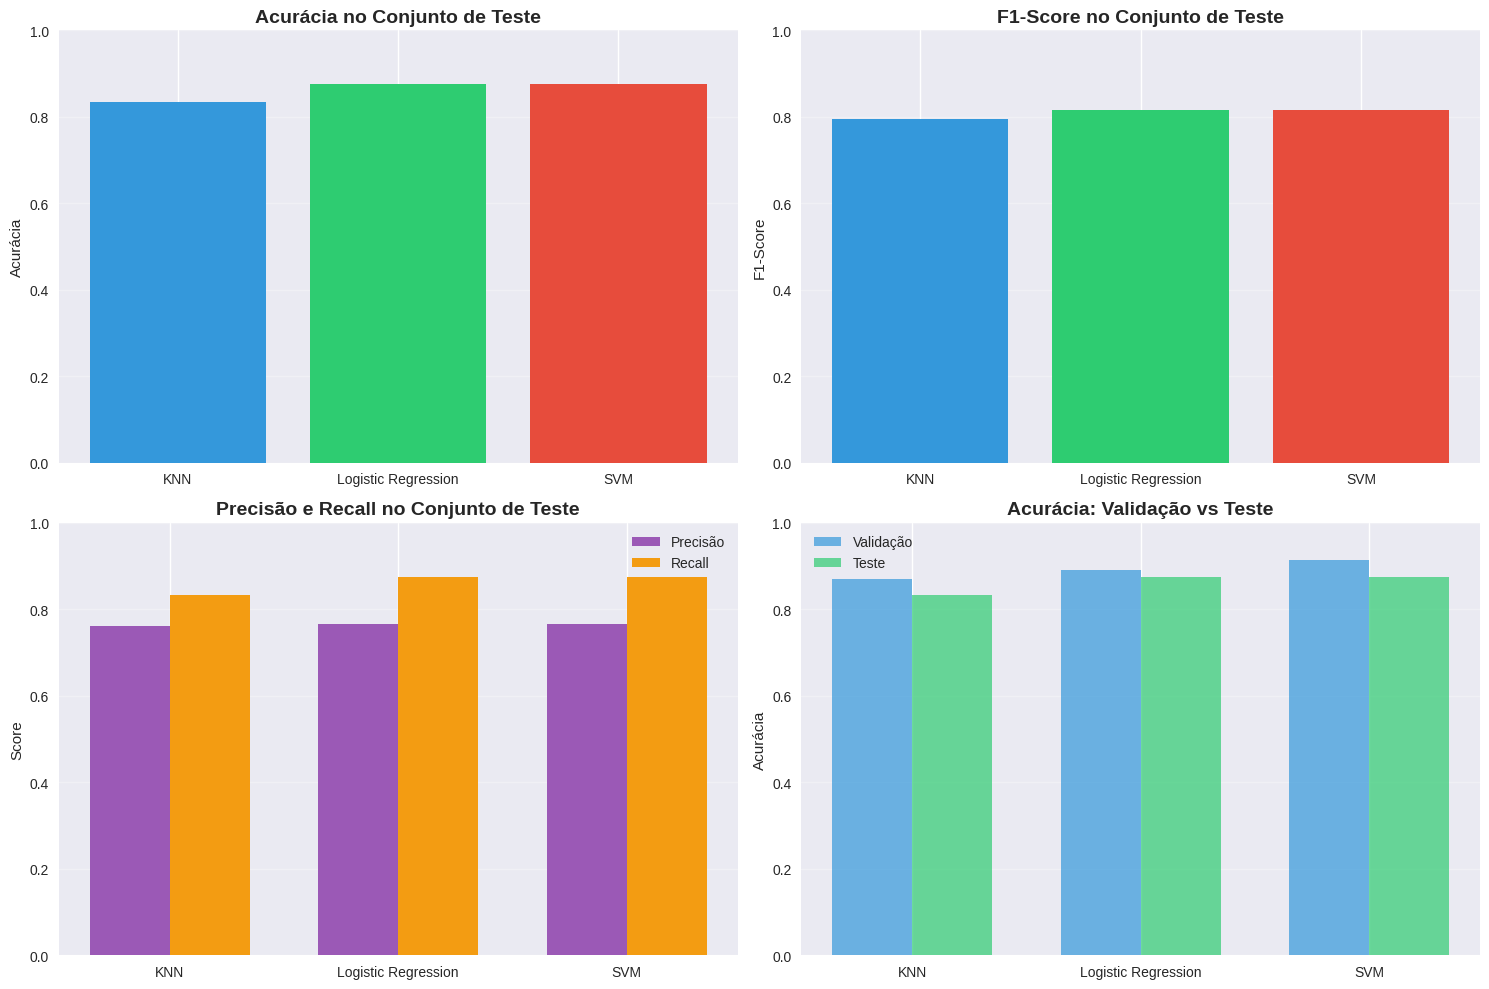

In [ ]:
# Criar Dataframe com os resultados
comparison_df = pd.DataFrame([
    {
        'Modelo': r['modelo'],
        'Acurácia (Validação)': r['val_accuracy'],
        'F1-Score (Validação)': r['val_f1'],
        'Acurácia (Teste)': r['test_accuracy'],
        'Precisão (Teste)': r['test_precision'],
        'Recall (Teste)': r['test_recall'],
        'F1-Score (Teste)': r['test_f1']
    }
    for r in results_all
])

print("Comparação dos Modelos:")
print("="*80)
print(comparison_df.to_string(index=False))

# Visualização gráfica
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1 se refere à Acurácia
axes[0, 0].bar(comparison_df['Modelo'], comparison_df['Acurácia (Teste)'], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[0, 0].set_title('Acurácia no Conjunto de Teste', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Acurácia')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)

# Gráfico 2 se refere ao F1-Score
axes[0, 1].bar(comparison_df['Modelo'], comparison_df['F1-Score (Teste)'], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[0, 1].set_title('F1-Score no Conjunto de Teste', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)

# Gráfico 3 se refere à Precisão e ao Recall
x = np.arange(len(comparison_df['Modelo']))
width = 0.35
axes[1, 0].bar(x - width/2, comparison_df['Precisão (Teste)'], width, label='Precisão', color='#9b59b6')
axes[1, 0].bar(x + width/2, comparison_df['Recall (Teste)'], width, label='Recall', color='#f39c12')
axes[1, 0].set_title('Precisão e Recall no Conjunto de Teste', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(comparison_df['Modelo'])
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)

# Gráfico 4 compara Validação vs Teste
x = np.arange(len(comparison_df['Modelo']))
width = 0.35
axes[1, 1].bar(x - width/2, comparison_df['Acurácia (Validação)'], width, label='Validação', color='#3498db', alpha=0.7)
axes[1, 1].bar(x + width/2, comparison_df['Acurácia (Teste)'], width, label='Teste', color='#2ecc71', alpha=0.7)
axes[1, 1].set_title('Acurácia: Validação vs Teste', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Acurácia')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(comparison_df['Modelo'])
axes[1, 1].legend()
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


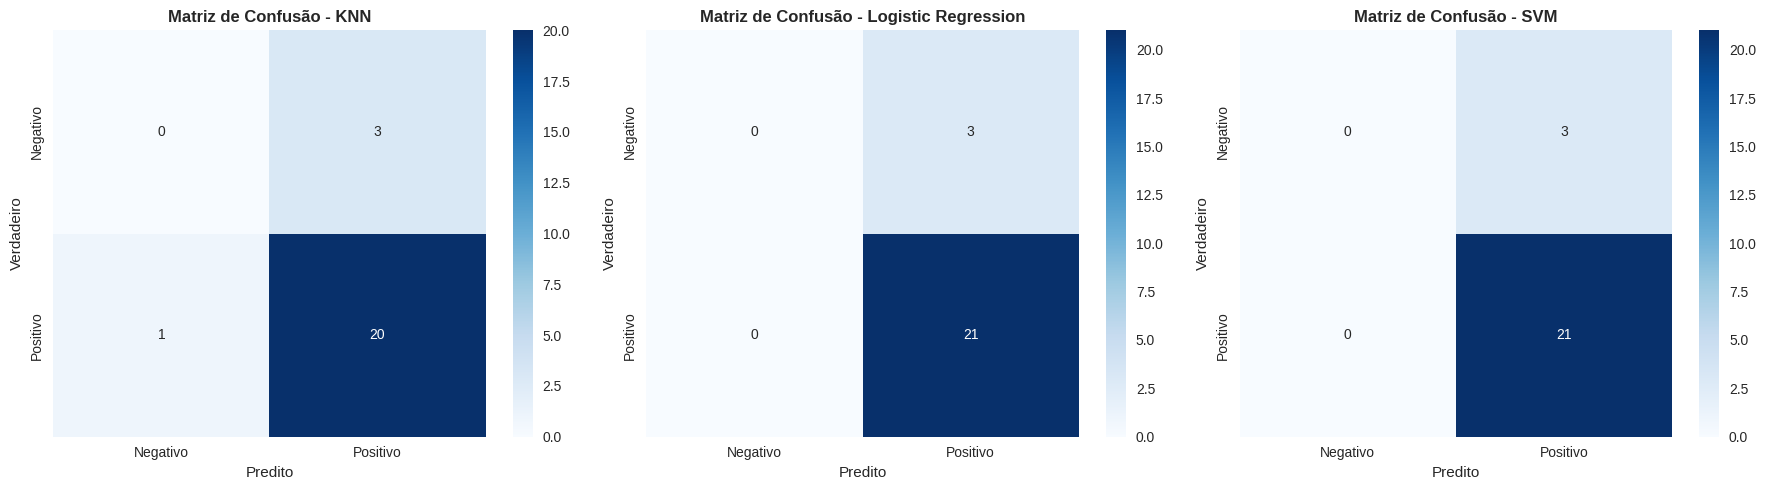

In [ ]:
# Plotar matrizes de confusão para cada um dos modelos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, result in enumerate(results_all):
    cm = confusion_matrix(y_test, result['y_test_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Negativo', 'Positivo'],
                yticklabels=['Negativo', 'Positivo'])
    axes[idx].set_title(f"Matriz de Confusão - {result['modelo']}", fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Verdadeiro')
    axes[idx].set_xlabel('Predito')

plt.tight_layout()
plt.show()
